# **Préparer les données**

### **Monter le dossier dans Drive**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
os.chdir('/content/drive/My Drive/Projet_HMIN339M')

### **Importation de quelques librairies**

In [16]:
import numpy as np
import tifffile
import glob
from pathlib import Path
import pandas as pd

### **Lecture de la série temporelle d'images et Normalisation par bande sur la série temporelle entre 0 et 1** 

#### **Lecture des images et création des séries temporelles de bandes**

In [17]:
# Récupérer la liste des images
lst_img = glob.glob ('Images/*.tif')
lst_img.sort() # ordonner par date si ce n'est pas le cas
lst_img

['Images/20160322_S2A.tif',
 'Images/20160710_S2A.tif',
 'Images/20160730_S2A.tif',
 'Images/20160928_S2A.tif',
 'Images/20161018_S2A.tif',
 'Images/20161127_S2A.tif',
 'Images/20161217_S2A.tif',
 'Images/20161227_S2A.tif']

In [18]:
# Lecture de la bande du rouge (B1) pour toute la série temporelle
red_ts = []
for img in lst_img:
  red_ts.append( tifffile.imread(img)[:,:,0]) # Rouge
red_ts = np.dstack(red_ts)
red_ts.shape

(5412, 5592, 8)

In [19]:
# Lecture de la bande du vert (B2) pour toute la série temporelle
green_ts = []
for img in lst_img:
  green_ts.append( tifffile.imread(img)[:,:,1]) # Vert
green_ts = np.dstack(green_ts)
green_ts.shape

(5412, 5592, 8)

In [20]:
# Lecture de la bande du bleu (B3) pour toute la série temporelle
blue_ts = []
for img in lst_img:
  blue_ts.append( tifffile.imread(img)[:,:,2]) # Bleu
blue_ts = np.dstack(blue_ts)
blue_ts.shape

(5412, 5592, 8)

In [21]:
# Lecture de la bande du proche infrarouge (B4) pour toute la série temporelle
nir_ts = []
for img in lst_img:
  nir_ts.append( tifffile.imread(img)[:,:,3]) # Proche infra rouge
nir_ts = np.dstack(nir_ts)
nir_ts.shape

(5412, 5592, 8)

In [22]:
# Calculer des indices spectraux comme le NDVI
ndvi_ts = np.where(nir_ts + red_ts == 0, 0, (nir_ts - red_ts) / (nir_ts + red_ts)).astype(np.float32)
ndvi_ts.shape, ndvi_ts.dtype, ndvi_ts.min(), ndvi_ts.max()

((5412, 5592, 8), dtype('float32'), -0.9994976, 0.99976385)

#### **Normalisation en utilisant le min et le max des bandes sur les séries temporelles**

In [23]:
# Normalisation des séries temporelles par bande: Rouge
red_ts_norm = ( red_ts - red_ts.min() ) / ( red_ts.max() - red_ts.min() ).astype(np.float32)
red_ts_norm.min() , red_ts_norm.max(), red_ts_norm.shape, red_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [24]:
# Normalisation des séries temporelles par bande: Vert
green_ts_norm = ( green_ts - green_ts.min() ) / ( green_ts.max() - green_ts.min() ).astype(np.float32)
green_ts = None
green_ts_norm.min() , green_ts_norm.max(), green_ts_norm.shape, green_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [25]:
# Normalisation des séries temporelles par bande: Bleu
blue_ts_norm = ( blue_ts - blue_ts.min() ) / ( blue_ts.max() - blue_ts.min() ).astype(np.float32)
blue_ts = None
blue_ts_norm.min() , blue_ts_norm.max(), blue_ts_norm.shape, blue_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [26]:
# Normalisation des séries temporelles par bande: Proche infrarouge
nir_ts_norm = ( nir_ts - nir_ts.min() ) / ( nir_ts.max() - nir_ts.min() ).astype(np.float32)
nir_ts_norm.min() , nir_ts_norm.max(), nir_ts_norm.shape, nir_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [27]:
# Normaliser les indices spectraux que vous aurez calculé
ndvi_ts_norm = ( ndvi_ts - ndvi_ts.min() ) / ( ndvi_ts.max() - ndvi_ts.min( )).astype(np.float32)
ndvi_ts_norm.min(), ndvi_ts_norm.max(), ndvi_ts_norm.shape, ndvi_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

### **Lecture de la vérité terrain et récupération des positions des pixels du jeu d'entraînement et de test**

#### **Lecture des fichiers de la vérité terrain**

In [28]:
# Lire le fichier correspondant aux classes d'occupation du sol
gt_class = tifffile.imread ('Verite_terrain/DORDOGNE_VT_CLASS.tif')
gt_class.shape , gt_class.dtype

((5412, 5592), dtype('uint8'))

In [29]:
# Lire le fichier correspondant aux identifiants
gt_id = tifffile.imread ('Verite_terrain/DORDOGNE_VT_ID.tif')
gt_id.shape, gt_id.dtype

((5412, 5592), dtype('int16'))

#### **Récupération des positions des pixels d'entraînement et de test**

In [30]:
# Récupérer les positions des échantillons d'entraînement et test
idx_train_ = np.where ( (gt_id!=0) & (gt_class!=0) )
idx_test = np.where ( (gt_id!=0) & (gt_class==0) )

In [31]:
# Lecture des identifiants et labels des échantillons d'entraînement
train_id_ = gt_id[idx_train_]
train_y_ = gt_class[idx_train_]
f'échantillons d\'entrainement: {train_y_.shape[0]} pixels, {len(np.unique(train_id_))} objets'

"échantillons d'entrainement: 605431 pixels, 1859 objets"

In [32]:
# Lecture des identifiants et labels des échantillons de test
test_id = gt_id[idx_test]
f'échantillons test: {test_id.shape[0]} pixels, {len(np.unique(test_id))} objets'

'échantillons test: 207485 pixels, 800 objets'

### **Création d'un jeu de validation en prenant une partie du jeu d'entraînement**
Pour cela, on s'assure de faire la division en mettant les pixels ayant le même identifiant dans un seul et même lot

In [33]:
# Dataframe pour créer un jeu de validation
samples = pd.DataFrame({'ID':train_id_,'Class':train_y_})
samples = samples.drop_duplicates(keep='first')
samples.head(5)

,ID,Class
0,422,2
4,2677,5
5,201,3
29,423,2
100,496,2


In [34]:
# 30% des échantillons de chaque classe affecté au jeu de validation
train_id = []
valid_id = []
for c in np.unique(samples.Class.values) :
    samples_c = samples.loc[samples.Class==c]
    samples_frac = samples_c.sample(frac=0.7,random_state=1234) 
    train_id.extend( samples_frac.ID.values )
    valid_id.extend( samples_c.drop(samples_frac.index).ID.values )
len(train_id),len(valid_id)

(1301, 558)

### **Récupération des positions des nouveaux échantillons d'entraînement et de validation**

In [35]:
# Récupérer les positions des nouveaux échantillons d'entraînement et validation
idx_train = np.where ( np.isin(gt_id,train_id) )
idx_valid = np.where ( np.isin(gt_id,valid_id) )

### **Lire finalement les labels correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [36]:
train_y = gt_class[idx_train]
valid_y = gt_class[idx_valid]
test_y = gt_class[idx_test]
train_y.shape, valid_y.shape, test_y.shape

((451962,), (153469,), (207485,))

### **Lire finalement les identifiants correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [37]:
# utile pour les aggrégations au niveau objet
# train_id_array = gt_id[idx_train] # Pas vraiment nécessaire pour les échantillons d'entraînements
valid_id_array = gt_id[idx_valid]
test_id_array = gt_id[idx_test]
#train_id_array.shape, 
valid_id_array.shape, test_id_array.shape

((153469,), (207485,))

### **Lire finalement les valeurs des séries temporelles correspondant aux nouveaux échantillons d'entraînement, de validation et test**

#### **Pour un Perceptron multi-couche**

In [38]:
# Un perceptron multi-couche ou un algo classique de machine learning requiert un tableau 2D du type 
# (nombre d'échantillons, nombre de features=(nombre de dates x nombre de bandes))
# Vous pouvez rajouter au stack les indices spectraux normalisés que vous aurez calculé

train_X = np.column_stack ( ( blue_ts_norm[idx_train], green_ts_norm[idx_train], red_ts_norm[idx_train], nir_ts_norm[idx_train] ) )

valid_X = np.column_stack ( ( blue_ts_norm[idx_valid], green_ts_norm[idx_valid], red_ts_norm[idx_valid], nir_ts_norm[idx_valid] ) )

test_X = np.column_stack ( ( blue_ts_norm[idx_test], green_ts_norm[idx_test], red_ts_norm[idx_test], nir_ts_norm[idx_test] ) )

train_X.shape, valid_X.shape, test_X.shape

((451962, 32), (153469, 32), (207485, 32))

#### **Pour un CNN 1D ou temporel**

In [39]:
# Un CNN 1D ou temporel requiert un tableau 3D du type (nombre d'échantillons, nombre de dates, nombre de bandes)
# Vous pouvez rajouter à la liste des bandes les indices spectraux normalisés que vous aurez calculé
train_X = []
for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    train_X.append( band[idx_train] ) 
train_X = np.stack(train_X,axis=-1)

valid_X = []
for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    valid_X.append( band[idx_valid] ) 
valid_X = np.stack(valid_X,axis=-1)

test_X = []
for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    test_X.append( band[idx_test] ) 
test_X = np.stack(test_X,axis=-1)

train_X.shape, valid_X.shape, test_X.shape

((451962, 8, 4), (153469, 8, 4), (207485, 8, 4))

#### **Pour un CNN2D ou spatial avec exemple d'imagettes ou patchs de 5 sur 5 en largeur et hauteur** 

Des patchs de 9 sur 9 sur l'ensemble des échantillons sont un peu trop gourmands en RAM pour Google Colab

In [40]:
# Un CNN 2D ou spatial requiert un tableau 3D du type (nombre d'échantillons, largeur, hauteur, nombre de features= (nombre de dates x nombre de bandes) )
# Vous pouvez rajouter à la liste des bandes les indices spectraux normalisés que vous aurez calculé

# Training
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_train[0]
idx_row = idx_train[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
train_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  train_X.append(np.stack(lst,axis=-1))#.reshape(5,5,-1))
train_X = np.stack(train_X,axis=0)
train_X.shape

(451962, 5, 5, 8, 4)

In [41]:
# Validation
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_valid[0]
idx_row = idx_valid[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
valid_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  valid_X.append(np.stack(lst,axis=-1))#.reshape(5,5,-1))
valid_X = np.stack(valid_X,axis=0)
valid_X.shape

(153469, 5, 5, 8, 4)

In [42]:
# Test
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_test[0]
idx_row = idx_test[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
test_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  test_X.append(np.stack(lst,axis=-1))#.reshape(5,5,-1))
test_X = np.stack(test_X,axis=0)
test_X.shape

(207485, 5, 5, 8, 4)

### **Sauvegarde des données d'entraînement, de validation et test en fichier numpy**

In [44]:
# Ainsi de cette façon vous pourrez continuer directement avec la création des modèles et en libérant la mémoire de tout ce qui a été fait précédemment
Path('data').mkdir(exist_ok=True, parents=True)
np.save('data/train_X.npy',train_X)
np.save('data/train_y.npy',train_y)
# np.save('data/train_id.npy',train_id_array)

np.save('data/valid_X.npy',valid_X)
np.save('data/valid_y.npy',valid_y)
np.save('data/valid_id.npy',valid_id_array)

np.save('data/test_X.npy',test_X)
np.save('data/test_id.npy',test_id_array)

Videz la mémoire en redémarrant l'environnement d'exécution

# **Votre modèle de deep learning**

### **Remontage de Drive et Importation de quelques librairies**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/Projet_HMIN339M')
import numpy as np
import pandas as pd
import tifffile
from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization, Flatten, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

### **Recharger les données d'entraînement, de validation et test en fichier numpy**

In [5]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('data/train_X.npy')
train_y = np.load('data/train_y.npy')

valid_X = np.load('data/valid_X.npy')
valid_y = np.load('data/valid_y.npy')
valid_id = np.load('data/valid_id.npy')

test_X = np.load('data/test_X.npy')
test_id = np.load('data/test_id.npy')
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, valid_id.shape, test_X.shape, test_id.shape

((451962, 5, 5, 8, 4),
 (451962,),
 (153469, 5, 5, 8, 4),
 (153469,),
 (153469,),
 (207485, 5, 5, 8, 4),
 (207485,))

In [6]:
train_X_mlp = train_X[:,2,2,:,:].reshape(train_X.shape[0],-1)
train_X_cnn1d = train_X[:,2,2,:,:]
train_X_cnn2d = train_X[:,:,:,:].reshape(train_X.shape[0],5,5,-1)

valid_X_mlp = valid_X[:,2,2,:,:].reshape(valid_X.shape[0],-1)
valid_X_cnn1d = valid_X[:,2,2,:,:]
valid_X_cnn2d = valid_X[:,:,:,:].reshape(valid_X.shape[0],5,5,-1)

test_X_mlp = test_X[:,2,2,:,:].reshape(test_X.shape[0],-1)
test_X_cnn1d = test_X[:,2,2,:,:]
test_X_cnn2d = test_X[:,:,:,:].reshape(test_X.shape[0],5,5,-1)

train_X_mlp.shape, train_X_cnn1d.shape, train_X_cnn2d.shape

((451962, 32), (451962, 8, 4), (451962, 5, 5, 32))

### **Encoder les labels entre 0 et 4 de sorte à matcher les prédictions des réseaux de neurones**

In [7]:
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_enc = encoder.transform(train_y)
valid_y_enc = encoder.transform(valid_y)
np.unique(train_y), np.unique(train_y_enc), np.unique(valid_y), np.unique(valid_y_enc)

(array([1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4]),
 array([1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4]))

### **Définition séquentielle de votre modèle avec Keras**

N'oubliez pas de spécifier l'input shape qui varie en fonction des types d'architectures, le nombre de neurones de la couche de sortie qui équivaut au nombre de classes que vous avez et de l'activer avec une fonction Softmax

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(32)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [9]:
# Afficher votre modèle
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 38,533
Trainable params: 38,533
Non-trainable params: 0
_________________________________________________________________


### **Définition de votre modèle en utilisant l'API fonctionnelle**

In [121]:
# Inputs 
mlp_input = Input(shape=(32),name='mlp_input')
cnn_input = Input(shape=(8,4),name='cnn_input')

# MLP branch
mlp_layer1 = Dense(128,activation='relu')(mlp_input)
mlp_layer1 = BatchNormalization()(mlp_layer1)
mlp_layer2 = Dense(256,activation='relu')(mlp_layer1)
mlp_layer2 = BatchNormalization()(mlp_layer2)
mlp_layer2 = Dropout(0.5)(mlp_layer2)
mlp_out = Dense(5,activation='softmax',name='mlp')(mlp_layer2)
mlp_branch = Model(inputs=mlp_input,outputs=[mlp_layer2,mlp_out],name="mlp")

# CNN branch
cnn_layer1 = Conv1D(filters=128,kernel_size=3,activation='relu')(cnn_input)
cnn_layer1 = BatchNormalization()(cnn_layer1)
cnn_layer2 = Conv1D(filters=256,kernel_size=3,activation='relu')(cnn_layer1)
cnn_layer2 = BatchNormalization()(cnn_layer2)
cnn_layer2 = Dropout(0.3)(cnn_layer2)
cnn_layer3 = GlobalAveragePooling1D()(cnn_layer2)
cnn_out = Dense(5,activation='softmax',name='cnn')(cnn_layer3)
cnn_branch = Model(inputs=cnn_input,outputs=[cnn_layer3,cnn_out],name="cnn")

# Concaténation des sorties des branches
concat = Concatenate()([mlp_branch.output[0],cnn_branch.output[0]])

# Un niveau Dense pour la classification
fc = Dense (128,activation='relu')(concat)
fc = Dropout (0.3)(fc)
out_layer = Dense(5,activation='softmax',name='main')(fc)


model = Model(inputs=[mlp_branch.input, cnn_branch.input], outputs=[out_layer,mlp_branch.output[1],cnn_branch.output[1]],name="mlp_cnn")

In [122]:
model.summary()

Model: "mlp_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 8, 4)]       0                                            
__________________________________________________________________________________________________
mlp_input (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 6, 128)       1664        cnn_input[0][0]                  
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 128)          4224        mlp_input[0][0]                  
____________________________________________________________________________________________

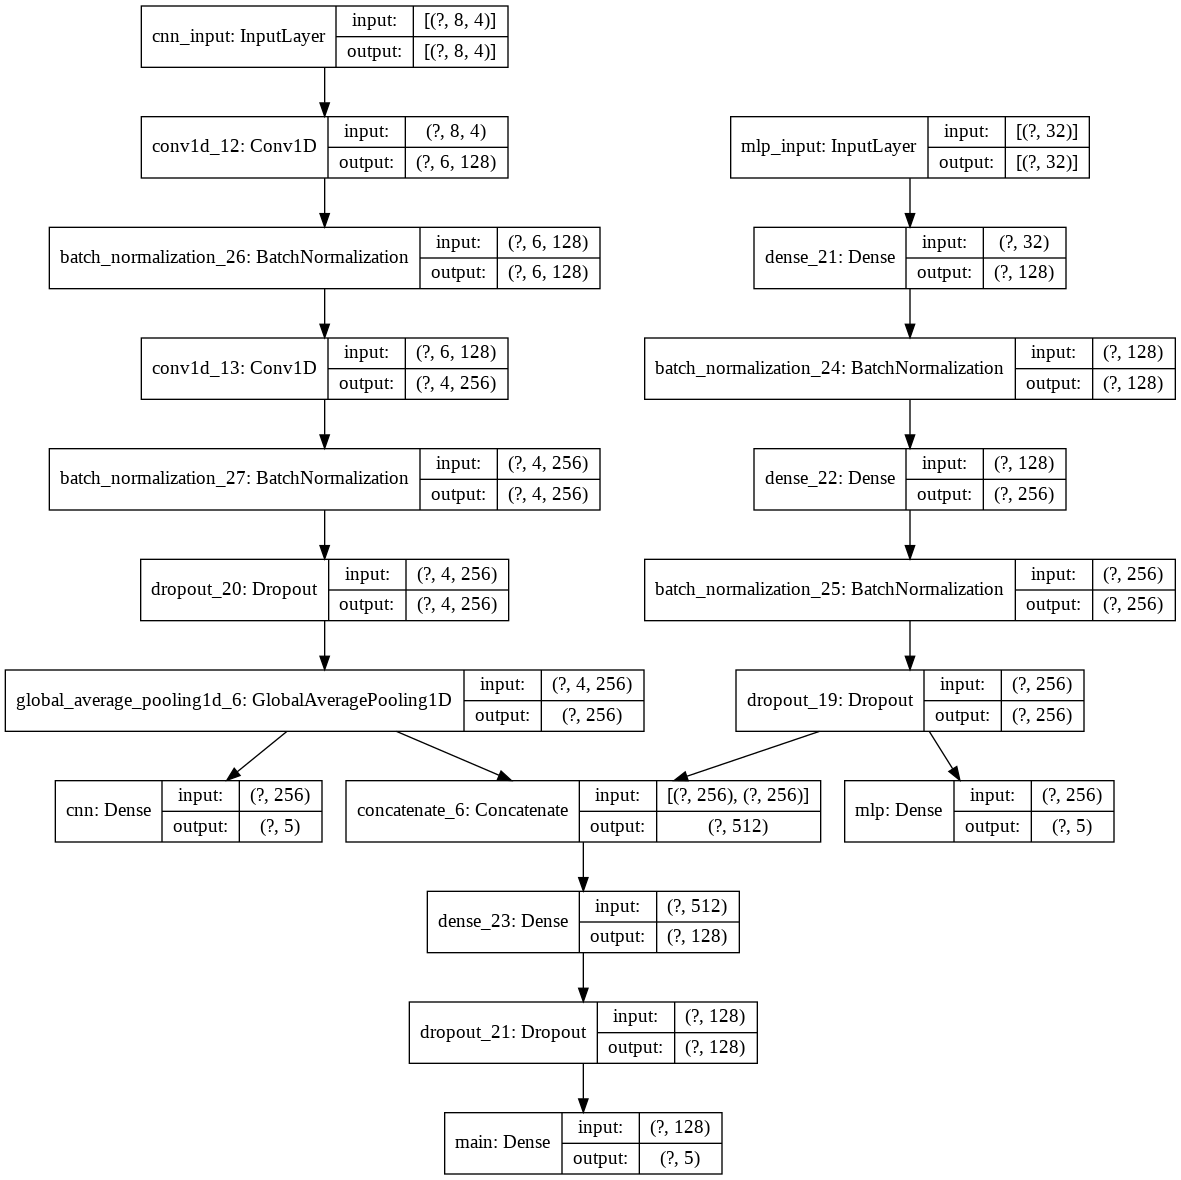

In [123]:
tf.keras.utils.plot_model(model,show_shapes=True)

### **Compiler votre modèle en définissant une fonction de côut, un optmiseur et une métrique**

Dans le cas d'une classification multi-classe, votre fonction de coût est la cross entropy catégorique. $Adam$ est un bon optimiseur de départ pour vos projets. Ici vous pouvez surveiller la métrique $Accuracy$. Pour la fonction de coût (loss), je n'utilse pas l'argument $from\_logits=True$ car j'ai déjà activé la couche de sortie avec une fonction Softmax

In [124]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4) ,loss=tf.keras.losses.SparseCategoricalCrossentropy(),loss_weights=[1,.5,.5], metrics=tf.keras.metrics.SparseCategoricalAccuracy(name='acc'))

### **Définir un callback pour sauver les poids de votre modèle sur les meilleures époque c'est à dire les moments où il s'améliorera sur le jeu de validation**

In [125]:
Path('my_model').mkdir(exist_ok=True, parents=True)
checkpointpath = os.path.join('my_model','model') # chemin où sauver le modèle
callbacks = [tf.keras.callbacks.ModelCheckpoint(
              checkpointpath,
              verbose=1, # niveau de log
              monitor='val_main_acc', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

### **Entraîner votre modèle pour un certain nombre d'époques**

Le paramètre $validation\_data$ vous permet de spécifier des données de validation et de votre le comportement de votre modèle sur un jeu indépendant dont il n'a pas la connaissance. 

La taille de batch ($batch\_size$) correspond au nombre d'échantillons sur lesquels le modèle est entraîné à la fois sur une époque. Vous pouvez le mettre à (ex. 32, 64, 128, 256) et plus il est grand ce qui requiert d'avoir de la mémoire plus le temps d'exécution d'une époque sera court

J'utilise les labels encodés entre 0 et 4 car la prédiction sur les distributions de probabilités du modèle est retournée avec un argmax

In [126]:
BATCH_SIZE = 256
EPOCHS = 50
hist = model.fit ([train_X_mlp,train_X_cnn1d], train_y_enc, validation_data=([valid_X_mlp,valid_X_cnn1d],valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
1760/1766 [============================>.] - ETA: 0s - loss: 0.9899 - main_loss: 0.4500 - mlp_loss: 0.6123 - cnn_loss: 0.4674 - main_acc: 0.8541 - mlp_acc: 0.8228 - cnn_acc: 0.8570
Epoch 00001: val_main_acc improved from -inf to 0.88598, saving model to my_model/model
1766/1766 [==============================] - 19s 11ms/step - loss: 0.9888 - main_loss: 0.4495 - mlp_loss: 0.6115 - cnn_loss: 0.4669 - main_acc: 0.8543 - mlp_acc: 0.8230 - cnn_acc: 0.8572 - val_loss: 0.6807 - val_main_loss: 0.3069 - val_mlp_loss: 0.4029 - val_cnn_loss: 0.3447 - val_main_acc: 0.8860 - val_mlp_acc: 0.8417 - val_cnn_acc: 0.8739
Epoch 2/50
1764/1766 [============================>.] - ETA: 0s - loss: 0.6169 - main_loss: 0.2846 - mlp_loss: 0.3575 - cnn_loss: 0.3073 - main_acc: 0.9024 - mlp_acc: 0.8837 - cnn_acc: 0.8968
Epoch 00002: val_main_acc improved from 0.88598 to 0.90175, saving model to my_model/model
1766/1766 [==============================] - 16s 9ms/step - loss: 0.6169 - main_loss: 0.2845 -

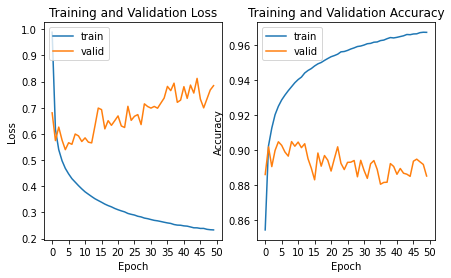

In [127]:
plt.figure(figsize=(7, 4))

ax = plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Training and Validation Loss")
plt.xticks(np.arange(0,EPOCHS+1,5),np.arange(0,EPOCHS+1,5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')

plt.subplot(122)
plt.plot(hist.history['main_acc'])
plt.plot(hist.history['val_main_acc'])
plt.title("Training and Validation Accuracy")
plt.xticks(np.arange(0,EPOCHS+1,5),np.arange(0,EPOCHS+1,5))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'valid'], loc='upper left')

### **Restaurer les poids du modèle sur la meilleure époque d'entraînement**

In [128]:
model.load_weights(checkpointpath)
# S'assurer que c'est bien le meilleur modèle sur les époques d'entraînement
model.evaluate([valid_X_mlp,valid_X_cnn1d],valid_y_enc,batch_size=256)

600/600 [==============================] - 2s 4ms/step - loss: 0.5926 - main_loss: 0.2898 - mlp_loss: 0.2844 - cnn_loss: 0.3212 - main_acc: 0.9048 - mlp_acc: 0.9009 - cnn_acc: 0.8936


[0.5925865769386292,
 0.2898143231868744,
 0.28438302874565125,
 0.3211613595485687,
 0.9048081636428833,
 0.9009050726890564,
 0.8935876488685608]

### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

In [129]:
# Récupérer les probabilités prédites sur le jeu de validation
valid_prob, _, _ = model.predict([valid_X_mlp,valid_X_cnn1d],batch_size=256)
valid_prob.shape

(153469, 5)

In [130]:
# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob,axis=1) # axe 1 car ceci concerne chaque ligne
valid_pred.shape

(153469,)

In [131]:
# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)
np.unique(valid_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [132]:
# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)
out_pred.shape

(558, 2)

In [133]:
# F1 score au niveau objet
f1_score(out_pred[:,0],out_pred[:,1],average='weighted')

0.8844484747509322

### **Prédire sur le jeu test et Préparer une soumission**

In [134]:
# Récupérer les probabilités prédites sur le jeu test
test_prob, _, _ = model.predict([test_X_mlp,test_X_cnn1d],batch_size=256)
test_prob.shape

(207485, 5)

In [135]:
# Retourner la classe correspondant à la probabilité la plus haute
test_pred = np.argmax(test_prob,axis=1) # axe 1 car ceci concerne chaque ligne
test_pred.shape

(207485,)

In [136]:
# Je réencode les prédictions entre 1 et 5
test_pred_enc = encoder.inverse_transform(test_pred)
np.unique(test_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [137]:
# Aggrégation au niveau objet
agg_pred = []
unique_id = np.unique(test_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = test_pred_enc[np.where(test_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
agg_pred = np.vstack(agg_pred)
agg_pred.shape

(800, 2)

In [138]:
df = pd.DataFrame({'ID':agg_pred[:,0],'Class':agg_pred[:,1]})
df.to_csv('Soumission_ASSARAR_BOUHLEL_DJAFER.csv',index=False)
df.head(5)

,ID,Class
0,4,5
1,7,3
2,8,5
3,9,3
4,10,3


In [139]:
# F1 Score au niveau objet
df_test = pd.read_csv('Test_ID_Label.csv') # Ce fichier vous sera fourni le 12 Novembre
f1_score(df_test.Class,df.Class,average='weighted')

0.8615788441188932

# **Segmentation**

In [140]:
!ls Images

20160322_S2A.tif  20160730_S2A.tif  20161018_S2A.tif  20161217_S2A.tif
20160710_S2A.tif  20160928_S2A.tif  20161127_S2A.tif  20161227_S2A.tif
